In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=8ff3db1b25375ff407013c92dfe3d19bf6e3eb15042568f8538f2406f08513ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-f0o6ax8q/wheels/55/59/29/0fb1c635652157

In [ ]:
from dul_2021.utils.hw11_utils import *

In [ ]:
import copy
from tqdm import tqdm

import torch.nn as nn
from torch.nn import functional as F
import torch
from torchvision.transforms.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from torchvision import transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim=1, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [ ]:
class BYOL(nn.Module):
    def __init__(self, latent_dim=128, tau=0.99):
        super().__init__()
        self.teacher = Net()
        self.student = copy.deepcopy(self.teacher)
        self.tau = tau

        self.transform = transforms.Compose([
              transforms.RandomResizedCrop(28),
              transforms.RandomHorizontalFlip(),
              transforms.GaussianBlur(9),
              transforms.Normalize(0.5, 0.5)])
                
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Linear(128, latent_dim)
        )
        
        self.teacher.requires_grad_(False)


    def update(self):
        for par_1, par_2 in zip(self.student.parameters(), self.teacher.parameters()):
            par_2.data = (self.tau * par_2.data + (1 - self.tau) * par_1.data)     

        
    def get_loss(self, x):
        transform_1 = self.transform(x)
        transform_2 = self.transform(x)

        norm_11 = torch.norm(self.predictor(self.student(transform_1)), dim=1)
        norm_12 = torch.norm(self.teacher(transform_2), dim=1)
        loss_1 = F.mse_loss(norm_11, norm_12)

        norm_21 = torch.norm(self.predictor(self.student(transform_2)), dim=1)
        norm_22 = torch.norm(self.teacher(transform_1), dim=1)
        loss_2 = F.mse_loss(norm_21, norm_22)
        
        return loss_1 + loss_2

    
    def fit(self, loader, epochs=20, lr=1e-4):
        model_params = list(self.teacher.parameters()) + list(self.student.parameters())
        optim = Adam(model_params, lr=lr)
        
        losses = []
        for epoch in tqdm(range(epochs)):
            for x, _ in loader:
                x = x.to(device)
                
                loss = self.get_loss(x)
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                self.update()
                losses.append(loss.item())
                
        return losses
    
    
    @torch.no_grad()
    def encode(self, x):
        x = transforms.Resize(28)(x)
        x = x.to(device)
        self.student.eval()
        return self.student(x).detach()

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

    loader = DataLoader(train_data, batch_size=128, shuffle=True)
    model = BYOL().to(device)
    losses = model.fit(loader)
    
    return losses, model.encode

100%|██████████| 20/20 [12:27<00:00, 37.39s/it]


mean classification accuracy=0.4905


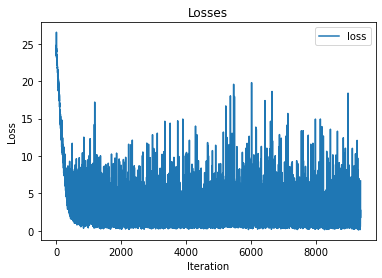

In [ ]:
q1_results(q1, True)

mean classification accuracy=0.6393


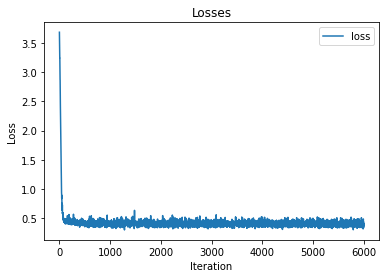

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim=1, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(input_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 7 * 7 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [ ]:
class BTWINS(nn.Module):
    def __init__(self, input_dim=3, latent_dim=128, lambd=1e-2):
        super().__init__()

        self.lambd = lambd
        self.latent_dim = latent_dim
        self.model = Net(input_dim=3)

        self.transform = transforms.Compose([
              transforms.RandomResizedCrop(28),
              transforms.RandomHorizontalFlip(),
              transforms.GaussianBlur(9),
              transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
              transforms.RandomGrayscale(0.2),              
              transforms.Normalize(0.5, 0.5)])
        
    def get_loss(self, x):
        transform_1 = self.transform(x)
        z_1 = self.model(transform_1)
        norm_1 = (z_1 - z_1.mean(0)) / z_1.std(0)
        
        transform_2 = self.transform(x)
        z_2 = self.model(transform_2)
        norm_2 = (z_2 - z_2.mean(0)) / z_2.std(0)

        cov_matrix = (norm_1.T @ norm_2) / (torch.sqrt((norm_1 ** 2).sum(0)) * torch.sqrt((norm_2 ** 2).sum(0)).reshape(-1, 1))
        n = cov_matrix.shape[0]
        loss_1 = ((1 - cov_matrix.diag()) ** 2).sum()

        mask = torch.eye(n, dtype=bool, device=device)
        temp = cov_matrix.masked_select(~mask)
        loss_2 = (temp.reshape(n, n - 1) ** 2).sum()
        
        return loss_1 + self.lambd * loss_2    
           

    def fit(self, loader, epochs=20, lr=5e-4):
        optim = Adam(self.parameters(), lr=lr)
        
        losses = []
        for epoch in tqdm(range(epochs)):
            for x, _ in loader:
                x = x.to(device)
                
                loss = self.get_loss(x)
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                losses.append(loss.item())
                
        return losses
 
    @torch.no_grad()
    def encode(self, x):
        x = transforms.Resize(28)(x)
        x = x.to(device)
        self.model.eval()
        return self.model(x).detach()

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    loader = DataLoader(train_data, batch_size=256, shuffle=True)
    model = BTWINS().to(device)
    losses = model.fit(loader)
    
    return losses, model.encode    

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 20/20 [05:51<00:00, 17.57s/it]


mean classification accuracy=0.3805


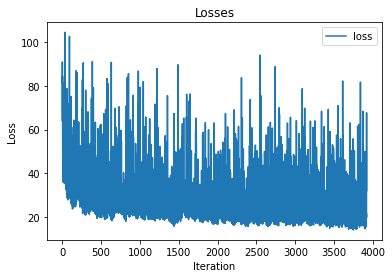

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)